# 生产计划优化问题

这是一个典型的线性规划问题，常见于数学建模比赛中。在这个问题中，我们将解决一个企业的生产计划优化问题。

## 问题描述

某企业生产两种产品A和B，每种产品需要使用三种原材料（原材料1、原材料2和原材料3）。企业希望制定一个最优的生产计划，以最大化总利润。

### 已知条件：

1. 产品A的利润为40元/件，产品B的利润为30元/件
2. 生产一件产品A需要：2单位原材料1，1单位原材料2，1单位原材料3
3. 生产一件产品B需要：1单位原材料1，1单位原材料2，2单位原材料3
4. 企业每周可用的原材料限制为：原材料1不超过40单位，原材料2不超过30单位，原材料3不超过30单位
5. 由于市场需求，产品A的生产量不能超过15件，产品B的生产量不能少于5件
6. 产品A和B的总生产量不能超过30件（生产线产能限制）

### 目标：

确定产品A和B的最优生产数量，使得总利润最大化。

## 数学模型的建立

### 决策变量
- $x_1$: 产品A的生产数量（件）
- $x_2$: 产品B的生产数量（件）

### 目标函数
最大化总利润：
$$\max Z = 40x_1 + 30x_2$$

### 约束条件

1. 原材料1的限制：$2x_1 + x_2 \leq 40$
2. 原材料2的限制：$x_1 + x_2 \leq 30$
3. 原材料3的限制：$x_1 + 2x_2 \leq 30$
4. 产品A的市场需求限制：$x_1 \leq 15$
5. 产品B的市场需求限制：$x_2 \geq 5$
6. 生产线产能限制：$x_1 + x_2 \leq 30$
7. 非负约束：$x_1, x_2 \geq 0$

In [2]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import pulp as pl

## 使用SciPy求解线性规划问题

首先，我们使用SciPy的linprog函数求解这个线性规划问题。注意，linprog默认是求解最小化问题，所以我们需要将目标函数取负。

In [3]:
# 目标函数系数（取负值，因为linprog默认求最小值）
c = [-40, -30]

# 不等式约束 A_ub @ x <= b_ub
A_ub = [
    [2, 1],    # 原材料1约束
    [1, 1],    # 原材料2约束
    [1, 2],    # 原材料3约束
    [1, 0],    # 产品A市场需求约束
    [1, 1],    # 生产线产能约束
    [-0, -1]   # 产品B市场需求约束（转换为 -x2 <= -5）
]
b_ub = [40, 30, 30, 15, 30, -5]

# 求解
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(0, None), method='highs')

# 输出结果
print("优化状态:", result.message)
print("产品A的最优生产量:", round(result.x[0]))
print("产品B的最优生产量:", round(result.x[1]))
print("最大利润:", round(-result.fun))  # 取负是因为我们之前将目标函数取了负

优化状态: Optimization terminated successfully. (HiGHS Status 7: Optimal)
产品A的最优生产量: 15
产品B的最优生产量: 8
最大利润: 825


不对呀 www

## 使用PuLP求解线性规划问题

接下来，我们使用PuLP库求解同样的问题。PuLP是一个更直观的线性规划求解器接口。

In [4]:
# 创建问题实例
model = pl.LpProblem(name="production-planning", sense=pl.LpMaximize)

# 定义决策变量
x1 = pl.LpVariable(name="x1", lowBound=0, cat='Integer')  # 产品A的生产量
x2 = pl.LpVariable(name="x2", lowBound=0, cat='Integer')  # 产品B的生产量

# 添加目标函数
model += 40 * x1 + 30 * x2, "利润"

# 添加约束条件
model += (2 * x1 + x2 <= 40, "原材料1约束")
model += (x1 + x2 <= 30, "原材料2约束")
model += (x1 + 2 * x2 <= 30, "原材料3约束")
model += (x1 <= 15, "产品A市场需求约束")
model += (x2 >= 5, "产品B市场需求约束")
model += (x1 + x2 <= 30, "生产线产能约束")

# 求解模型
model.solve()

# 输出结果
print(f"状态: {pl.LpStatus[model.status]}")
print(f"产品A的最优生产量: {int(pl.value(x1))}")
print(f"产品B的最优生产量: {int(pl.value(x2))}")
print(f"最大利润: {int(pl.value(model.objective))}")

状态: Optimal
产品A的最优生产量: 15
产品B的最优生产量: 7
最大利润: 810


## 图形化解释

我们可以通过绘制可行域和等利润线来直观地理解这个问题。

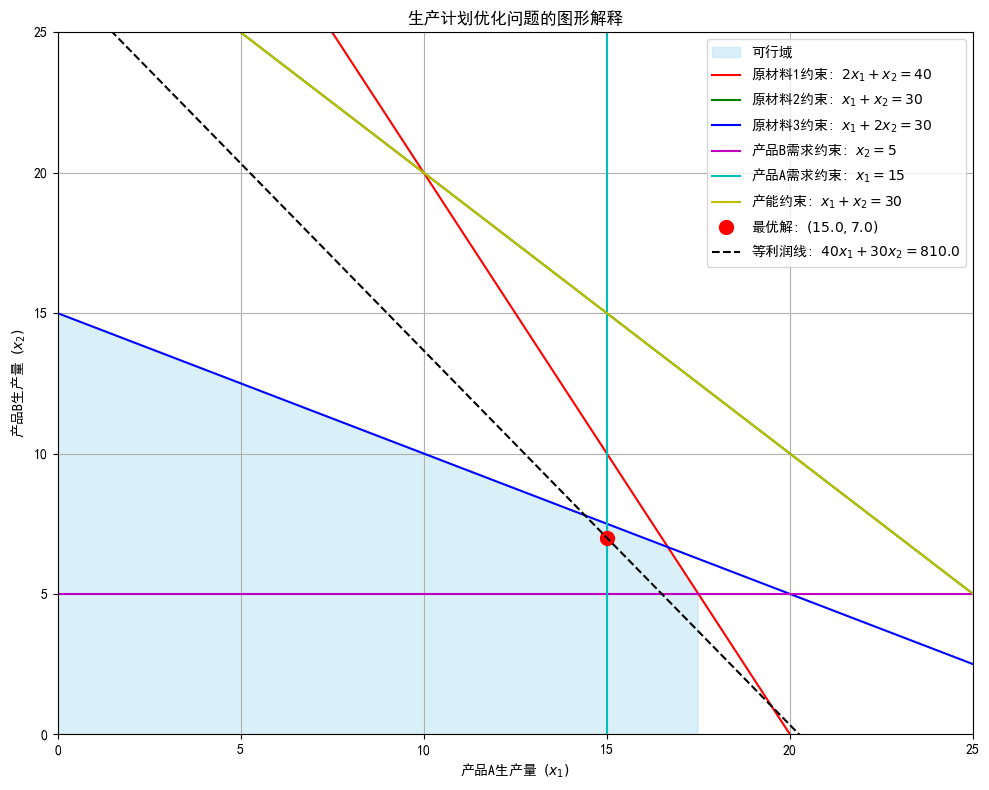

In [8]:

# 设置中文字体，以防绘图时出现乱码
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 解决中文字符的显示问题
plt.rcParams["axes.unicode_minus"] = False  # 解决因第一行操作而可能引发的负号显示问题

# 创建网格点
x1_values = np.linspace(0, 30, 1000)
x2_values = np.linspace(0, 30, 1000)
X1, X2 = np.meshgrid(x1_values, x2_values)

# 设置图形大小
plt.figure(figsize=(10, 8))

# 绘制约束条件
plt.fill_between(x1_values, 0, np.minimum(40 - 2*x1_values, np.minimum(30 - x1_values, np.minimum(15, np.minimum(30 - x1_values, (30 - x1_values)/2)))), 
                 where=(x1_values >= 0) & (40 - 2*x1_values >= 5) & (30 - x1_values >= 5) & ((30 - x1_values)/2 >= 5), 
                 alpha=0.3, color='skyblue', label='可行域')

# 绘制约束线
plt.plot(x1_values, 40 - 2*x1_values, 'r-', label=r'原材料1约束: $2x_1 + x_2 = 40$')
plt.plot(x1_values, 30 - x1_values, 'g-', label=r'原材料2约束: $x_1 + x_2 = 30$')
plt.plot(x1_values, (30 - x1_values)/2, 'b-', label=r'原材料3约束: $x_1 + 2x_2 = 30$')
plt.plot(x1_values, np.ones_like(x1_values) * 5, 'm-', label=r'产品B需求约束: $x_2 = 5$')
plt.plot(np.ones_like(x2_values) * 15, x2_values, 'c-', label=r'产品A需求约束: $x_1 = 15$')
plt.plot(x1_values, 30 - x1_values, 'y-', label=r'产能约束: $x_1 + x_2 = 30$')

# 绘制最优解
optimal_x1 = pl.value(x1)
optimal_x2 = pl.value(x2)
plt.plot(optimal_x1, optimal_x2, 'ro', markersize=10, label=rf'最优解: $({optimal_x1}, {optimal_x2})$')

# 绘制等利润线
profit = pl.value(model.objective)
x1_profit = np.linspace(0, 30, 100)
x2_profit = (profit - 40 * x1_profit) / 30
plt.plot(x1_profit, x2_profit, 'k--', label=rf'等利润线: $40x_1 + 30x_2 = {profit}$')

# 设置图形属性
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.xlabel(r'产品A生产量 $(x_1)$')
plt.ylabel(r'产品B生产量 $(x_2)$')
plt.title('生产计划优化问题的图形解释')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## 敏感性分析

敏感性分析可以帮助我们了解参数变化对最优解的影响。我们可以分析原材料供应量变化对最大利润的影响。

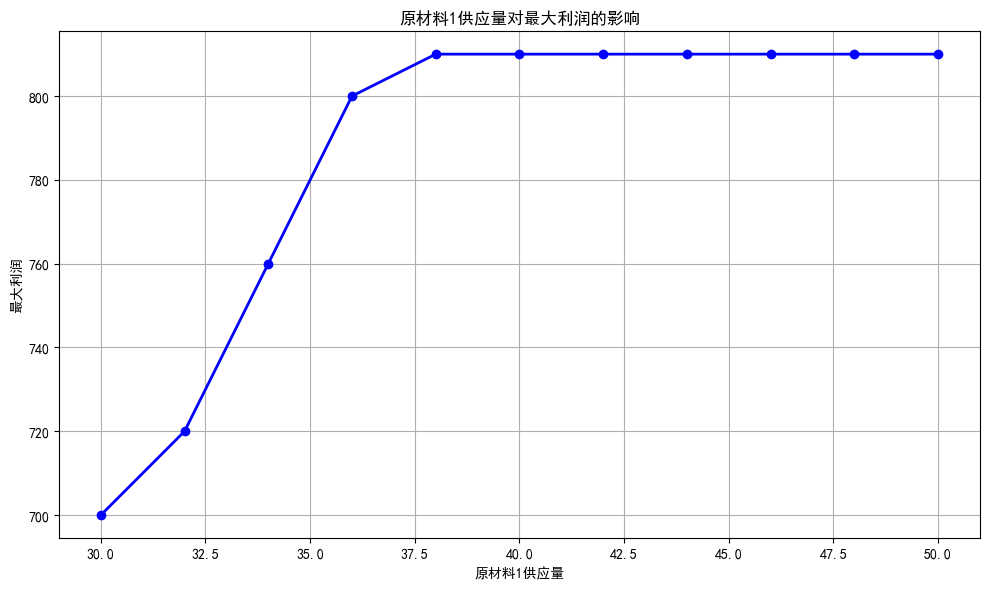

In [7]:
# 分析原材料1供应量变化对最大利润的影响
material1_range = range(30, 51, 2)  # 原材料1供应量从30到50
profits = []

for supply in material1_range:
    # 创建新模型
    model = pl.LpProblem(name="sensitivity-analysis", sense=pl.LpMaximize)
    
    # 定义决策变量
    x1 = pl.LpVariable(name="x1", lowBound=0, cat='Integer')
    x2 = pl.LpVariable(name="x2", lowBound=0, cat='Integer')
    
    # 添加目标函数
    model += 40 * x1 + 30 * x2, "利润"
    
    # 添加约束条件（更新原材料1供应量）
    model += (2 * x1 + x2 <= supply, "原材料1约束")
    model += (x1 + x2 <= 30, "原材料2约束")
    model += (x1 + 2 * x2 <= 30, "原材料3约束")
    model += (x1 <= 15, "产品A市场需求约束")
    model += (x2 >= 5, "产品B市场需求约束")
    model += (x1 + x2 <= 30, "生产线产能约束")
    
    # 求解模型
    model.solve(pl.PULP_CBC_CMD(msg=False))
    
    # 记录最大利润
    profits.append(pl.value(model.objective))

# 绘制敏感性分析图
plt.figure(figsize=(10, 6))
plt.plot(material1_range, profits, 'bo-', linewidth=2)
plt.xlabel('原材料1供应量')
plt.ylabel('最大利润')
plt.title('原材料1供应量对最大利润的影响')
plt.grid(True)
plt.tight_layout()
plt.show()

## 结论

通过求解这个线性规划问题，我们得到了最优的生产计划：

1. 产品A应该生产的数量
2. 产品B应该生产的数量
3. 最大可获得的利润

从敏感性分析中，我们可以看出原材料1的供应量对最大利润的影响。这种分析对企业决策非常有价值，可以帮助企业确定是否值得增加原材料的采购量。

这个例子展示了线性规划在生产计划优化中的应用，是数学建模比赛中常见的问题类型。